<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# 3.0 Build a Named Entity Recognizer
### (NVIDIA NeMo v1.0)

In this notebook, you'll build an NER (named entity recognition) application that finds disease names in medical disease abstracts. The model does not "search" for names from a list, but rather "recognizes" that certain words are disease references from the context of the language. 

**[3.1 Token Classification from the Command Line](#3.1-Token-Classification-from-the-Command-Line)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Data Input](#3.1.1-Data-Input)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1.1 IOB Tagging](#3.1.1.1-IOB-Tagging)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Configuration File](#3.1.2-Configuration-File)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.3 Hydra-Enabled Python Scripts](#3.1.3-Hydra-Enabled-Python-Scripts)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.4 Exercise: Train the Model](#3.1.4-Exercise:-Train-the-Model)<br>
**[3.2 Domain-Specific Training](#3.2-Domain-Specific-Training)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1 Visualize the Results with TensorBoard](#3.2.1-Visualize-the-Results-with-TensorBoard)<br>
**[3.3 Evaluation](#3.3-Evaluation)**<br>
**[3.4 Inference](#3.4-Inference)**<br>

For the NER task, you'll follow the same basic steps as in the text classification task to build your project, train it, and test it.  This time, however, you'll train a classifier on the *domain-specific* BioMegatron language model.  BioMegatron is a [BERT](https://arxiv.org/abs/1810.04805)-like [Megatron-LM](https://arxiv.org/pdf/1909.08053.pdf) model pre-trained on a large biomedical text corpus ([PubMed](https://pubmed.ncbi.nlm.nih.gov/) abstracts and full-text commercial use collection).  We can expect to have better performance compared to the general language models, because our disease dataset is from the same biomedical domain.

There are some alternatives of BioMegatron, most notably [BioBERT](https://arxiv.org/abs/1901.08746). Compared to BioBERT, BioMegatron is larger by model size and pre-trained on larger text corpus.

---
# 3.1 Token Classification from the Command Line
The question we want to answer is:

**Given sentences from medical abstracts, what diseases are mentioned?**<br>

Recall the NLP models available with NeMo:

In [1]:
!tree nemo/examples/nlp -L 1

nemo/examples/nlp
├── dialogue_state_tracking
├── entity_linking
├── glue_benchmark
├── information_retrieval
├── intent_slot_classification
├── language_modeling
├── machine_translation
├── question_answering
├── text2sparql
├── text_classification
└── token_classification

11 directories, 0 files


We use the [token classification](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html) model for NER because we are classifying at the "token" level, in this case classifying words related to diseases.

## 3.1.1 Data Input
As we saw in the [1.0 Explore the Data](010_ExploreData.ipynb) notebook, the dataset for the NER project is made up of sentences with IOB tagging for disease names, where each word in a sentence is tagged as inside, outside, or the beginning of a named entity. 

The training text and label files are `text_train.txt` and `labels_train.txt`, respectively.  The validation and test files follow a similar naming pattern. Verify the location of the data files. 

In [4]:
NER3_DATA_DIR = '/dli/task/data/NCBI_ner-3'
!ls -lh $NER3_DATA_DIR

total 4.0M
-rw-r--r-- 1 702112 10513  181K Jul 13  2020 dev.tsv
-rw-r--r-- 1 702112 10513     5 Jul 13  2020 label_ids.csv
-rw-r--r-- 1 702112 10513    52 Jul 13  2020 label_stats.tsv
-rw-r--r-- 1 702112 10513   48K Jul 13  2020 labels_dev.txt
-rw-r--r-- 1 702112 10513   49K Jul 13  2020 labels_test.txt
-rw-r--r-- 1 702112 10513  271K Jul 13  2020 labels_train.txt
-rw-r--r-- 1 702112 10513  185K Jul 13  2020 test.tsv
-rw-r--r-- 1 702112 10513  135K Jul 13  2020 text_dev.txt
-rw-r--r-- 1 702112 10513  138K Jul 13  2020 text_test.txt
-rw-r--r-- 1 702112 10513  758K Jul 13  2020 text_train.txt
-rw-r--r-- 1 702112 10513 1023K Jul 13  2020 train.tsv
-rw-r--r-- 1 702112 10513  1.2M Jul 13  2020 train_dev.tsv


In [5]:
# Take a look at the data
print("*****\ntext_test.txt sample\n*****")
!head -n 3 $NER3_DATA_DIR/text_test.txt
print("\n*****\nlabels_test.txt sample\n*****")
!head -n 3 $NER3_DATA_DIR/labels_test.txt

*****
text_test.txt sample
*****
Clustering of missense mutations in the ataxia - telangiectasia gene in a sporadic T - cell leukaemia . 
Ataxia - telangiectasia ( A - T ) is a recessive multi - system disorder caused by mutations in the ATM gene at 11q22 - q23 ( ref . 3 ) . 
The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A - T patients and has long been associated with chromosomal instability . 

*****
labels_test.txt sample
*****
O O O O O O B I I O O O B I I I I O 
B I I O B I I O O O B I I I I O O O O O O O O O O O O O O O O O 
O O O B O O B I O O O O O B I I O O O O O O O O O O 


### 3.1.1.1 IOB Tagging
Recall that the sentences and labels in the NER dataset map to each other with _inside, outside, beginning (IOB)_ tagging.
This mechanism can be used in a general way for multiple named entity types:
* B-{CHUNK_TYPE} – for the word in the Beginning chunk
* I-{CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

In our case, we are only looking for "disease" as our entity (or chunk) type, so we don't need to identify beyond the three classes: I, O, and B.
**Three classes**
* B - Beginning of disease name
* I - Inside word of disease name
* O - Outside of all disease names

```text
Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
O              O  O    O O O         O  O   B           I         I    I      O          O  
```

These are defined in our `labels.csv` file:

In [6]:
!head $NER3_DATA_DIR/label_ids.csv

O
B
I

If we were looking for two kinds of named entities, such as nouns and verbs in a parts-of-speech analysis, we would use a five-class IOB scheme:<br>
**Five classes**
* B-N - Beginning of noun word or phrase
* I-N - Inside noun word or phrase
* B-V - Beginning of verb word or phrase
* I-V - Inside verb word or phrase
* O   - Outside all nouns and verbs

If you are intereested in learning more, take a look at [this paper](http://cs229.stanford.edu/proj2005/KrishnanGanapathy-NamedEntityRecognition.pdf) on the subject.

The NCBI_ner-3 disease data is in the correct format for token classification as described in the [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html#data-input-for-token-classification-model), so we are ready to look at the configuration file.

## 3.1.2 Configuration File
Look at more detail for the NeMo token classification directory:

In [7]:
TC_DIR = "/dli/task/nemo/examples/nlp/token_classification"
!tree $TC_DIR

/dli/task/nemo/examples/nlp/token_classification
├── conf
│   ├── punctuation_capitalization_config.yaml
│   └── token_classification_config.yaml
├── data
│   ├── get_tatoeba_data.py
│   ├── import_from_iob_format.py
│   └── prepare_data_for_punctuation_capitalization.py
├── punctuation_capitalization_evaluate.py
├── punctuation_capitalization_train.py
├── token_classification_evaluate.py
└── token_classification_train.py

2 directories, 9 files


The config file for NER, `token_classification_config.yaml`, specifies model, training, and experiment management details, such as file locations, pretrained models, and hyperparameters.  This is the same general pattern used in the text classification configuration file.  We'll take a look at the details of each section using the `OmegaConf` tool introduced in the text classification project.

In [8]:
from omegaconf import OmegaConf

CONFIG_DIR = "/dli/task/nemo/examples/nlp/token_classification/conf"
CONFIG_FILE = "token_classification_config.yaml"

config = OmegaConf.load(CONFIG_DIR + "/" + CONFIG_FILE)

# print the model section
print(OmegaConf.to_yaml(config.model))

label_ids: null
class_labels:
  class_labels_file: label_ids.csv
dataset:
  data_dir: ???
  class_balancing: null
  max_seq_length: 128
  pad_label: O
  ignore_extra_tokens: false
  ignore_start_end: false
  use_cache: true
  num_workers: 2
  pin_memory: false
  drop_last: false
train_ds:
  text_file: text_train.txt
  labels_file: labels_train.txt
  shuffle: true
  num_samples: -1
  batch_size: 64
validation_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
test_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
tokenizer:
  tokenizer_name: ${model.language_model.pretrained_model_name}
  vocab_file: null
  tokenizer_model: null
  special_tokens: null
language_model:
  pretrained_model_name: bert-base-uncased
  lm_checkpoint: null
  config_file: null
  config: null
head:
  num_fc_layers: 2
  fc_dropout: 0.5
  activation: relu
  use_transformer_init: true
optim:
  na

In [9]:
# complete list of supported BERT-like models
from nemo.collections import nlp as nemo_nlp
nemo_nlp.modules.get_pretrained_lm_models_list()

['megatron-bert-345m-uncased',
 'megatron-bert-345m-cased',
 'megatron-bert-uncased',
 'megatron-bert-cased',
 'biomegatron-bert-345m-uncased',
 'biomegatron-bert-345m-cased',
 'bert-base-uncased',
 'bert-large-uncased',
 'bert-base-cased',
 'bert-large-cased',
 'bert-base-multilingual-uncased',
 'bert-base-multilingual-cased',
 'bert-base-chinese',
 'bert-base-german-cased',
 'bert-large-uncased-whole-word-masking',
 'bert-large-cased-whole-word-masking',
 'bert-large-uncased-whole-word-masking-finetuned-squad',
 'bert-large-cased-whole-word-masking-finetuned-squad',
 'bert-base-cased-finetuned-mrpc',
 'bert-base-german-dbmdz-cased',
 'bert-base-german-dbmdz-uncased',
 'cl-tohoku/bert-base-japanese',
 'cl-tohoku/bert-base-japanese-whole-word-masking',
 'cl-tohoku/bert-base-japanese-char',
 'cl-tohoku/bert-base-japanese-char-whole-word-masking',
 'TurkuNLP/bert-base-finnish-cased-v1',
 'TurkuNLP/bert-base-finnish-uncased-v1',
 'wietsedv/bert-base-dutch-cased',
 'distilbert-base-uncased

In the `model` section, a path for `dataset.data_dir` that contains all the data files is required.  The actual file names we are using already conform to the default values, so we don't need to override those.

For our first try, we can override `language_model.pretrained_model_name` to `bert-base-cased`, so we can compare the results to the domain-specific `biomegatron-bert-345m-cased` in another experiment.  Since we will need to conserve memory space to run BioMegatron, we will go ahead and reduce `dataset.max_seq_length` and the `batch_size`.

In [10]:
# print the trainer section
print(OmegaConf.to_yaml(config.trainer))

gpus: 1
num_nodes: 1
max_epochs: 5
max_steps: null
accumulate_grad_batches: 1
gradient_clip_val: 0.0
amp_level: O0
precision: 16
accelerator: ddp
checkpoint_callback: false
logger: false
log_every_n_steps: 1
val_check_interval: 1.0
resume_from_checkpoint: null



For efficiency, we can set the `amp_level` to 'O1'.  Since the language models we are going to compare are large and take a long time to run, we will override the `max_epochs` to a small number. 

In [11]:
# print the experiment manager section
print(OmegaConf.to_yaml(config.exp_manager))

exp_dir: null
name: token_classification_model
create_tensorboard_logger: true
create_checkpoint_callback: true



There is no need to change the `exp_manger` default settings for now.

###### 3.1.3 Hydra-Enabled Python Scripts
The Python scripts, `token_classification_train.py` and `token_evaluate.py`, encapsulate everything needed to run a token classification experiment defined by the configuration file.  Training and evaluation are expected to be run separately in this case.  As with text classification, both scripts employ Facebook's [Hydra](https://hydra.cc/) tool for configuration management, which allows the entire experiment to be run from the command line, overriding config file values as needed.

To recap, the parameters we need to change or override are:

* `model.language_model.pretrained_model_name`: set to 'bert-base-cased'
* `model.dataset.data_dir`: set to /dli/task/data/NCBI_ner-3
* `model.dataset.max_seq_length`: 64
* `model.train_ds.batch_size`: set to 32
* `model.val_ds.batch_size`: set to 32
* `model.test_ds.batch_size`: set to 32
* `trainer.amp_level`: set to "O1"
* `trainer.max_epochs`: set to 3

## 3.1.4 Exercise: Train the Model
Run the training script, `token_classification_train.py` just as you ran similar experiments in text classification notebook.   

The new values for overrides are provided for you in the cell below.  Add the command with appropriate overrides and run the cell.  If you get stuck, refer to the [solution](solutions/ex3.1.4.ipynb).

In [13]:
%%time
# The training takes about 2 minutes to run
   
TOKEN_DIR = "/dli/task/nemo/examples/nlp/token_classification"

# set the values we want to override
PRETRAINED_MODEL_NAME = 'bert-base-cased'
DATA_DIR = '/dli/task/data/NCBI_ner-3'
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 32
AMP_LEVEL = 'O1'
MAX_EPOCHS = 3

# Override the config values in the command line
# Override the config values in the command line
!python $TOKEN_DIR/token_classification_train.py \
        model.language_model.pretrained_model_name=$PRETRAINED_MODEL_NAME \
        model.dataset.data_dir=$DATA_DIR \
        model.dataset.max_seq_length=$MAX_SEQ_LENGTH \
        model.train_ds.batch_size=$BATCH_SIZE \
        model.validation_ds.batch_size=$BATCH_SIZE \
        model.test_ds.batch_size=$BATCH_SIZE \
        trainer.amp_level=$AMP_LEVEL \
        trainer.max_epochs=$MAX_EPOCHS

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
[NeMo I 2022-01-25 19:27:44 exp_manager:216] Experiments will be logged at /dli/task/nemo_experiments/token_classification_model/2022-01-25_19-27-44
[NeMo I 2022-01-25 19:27:44 exp_manager:563] TensorboardLogger has been set up
[NeMo I 2022-01-25 19:27:44 token_classification_train:109] Config: pretrained_model: null
    trainer:
      gpus: 1
      num_nodes: 1
      max_epochs: 3
      max_steps: null
      accumulate_grad_batches: 1
      gradient_clip_val: 0.0
      amp_level: O1
      precision: 16
      accelerator: ddp
      checkpoint_callback: false
      logger: false
      log_every_n_steps: 1
      val_check_interval: 1.0
      resume_from_checkpoint: null
    exp_manager:
      exp_dir: null
      name: token_classification_model
      create_tensorboard_logger: true
      create_checkpoint_callback: true
    model:
      label_ids: null
      class_labels:
        class_

How were the results?  Your log should have included something like:

```
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.34      99.35      99.34      21648
    B (label_id: 1)                                         85.86      89.21      87.50        769
    I (label_id: 2)                                         91.74      89.00      90.35       1073
    -------------------
    micro avg                                               98.54      98.54      98.54      23490
    macro avg                                               92.31      92.52      92.40      23490
    weighted avg                                            98.55      98.54      98.55      23490
    
Epoch 2: 100%|█| 199/199 [00:15<00:00, 12.45it/s, loss=0.0251, v_num=4-43, val_l
```

---
# 3.2 Domain-Specific Training

Try another experiment, this time overriding the `model.language_model.pretrained_model_name` with `biomegatron-bert-345m-cased`.  This is a large model with 345 million parameter.  Therefore, it takes longer to run.

In [14]:
%%time
# The training takes about 5-6 minutes to run
   
TOKEN_DIR = "/dli/task/nemo/examples/nlp/token_classification"

# set the values we want to override
PRETRAINED_MODEL_NAME = 'biomegatron-bert-345m-cased'
DATA_DIR = '/dli/task/data/NCBI_ner-3'
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 32
AMP_LEVEL = 'O1'
MAX_EPOCHS = 3

# Override the config values in the command line
!python $TOKEN_DIR/token_classification_train.py \
        model.language_model.pretrained_model_name=$PRETRAINED_MODEL_NAME \
        model.dataset.data_dir=$DATA_DIR \
        model.dataset.max_seq_length=$MAX_SEQ_LENGTH \
        model.train_ds.batch_size=$BATCH_SIZE \
        model.validation_ds.batch_size=$BATCH_SIZE \
        model.test_ds.batch_size=$BATCH_SIZE \
        trainer.amp_level=$AMP_LEVEL \
        trainer.max_epochs=$MAX_EPOCHS

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
[NeMo I 2022-01-25 19:29:52 exp_manager:216] Experiments will be logged at /dli/task/nemo_experiments/token_classification_model/2022-01-25_19-29-52
[NeMo I 2022-01-25 19:29:52 exp_manager:563] TensorboardLogger has been set up
[NeMo I 2022-01-25 19:29:52 token_classification_train:109] Config: pretrained_model: null
    trainer:
      gpus: 1
      num_nodes: 1
      max_epochs: 3
      max_steps: null
      accumulate_grad_batches: 1
      gradient_clip_val: 0.0
      amp_level: O1
      precision: 16
      accelerator: ddp
      checkpoint_callback: false
      logger: false
      log_every_n_steps: 1
      val_check_interval: 1.0
      resume_from_checkpoint: null
    exp_manager:
      exp_dir: null
      name: token_classification_model
      create_tensorboard_logger: true
      create_checkpoint_callback: true
    model:
      label_ids: null
      class_labels:
        class_

## 3.2.1 Visualize the Results with TensorBoard
The [experiment manager](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/core.html?highlight=tensorboard#experiment-manager) saves results for viewing with TensorBoard. Execute the following cell to create a link to TensorBoard for your instance, then click on the link to open Tensorboard in a tab on your browser.

In [15]:
%%js
const href = window.location.hostname +'/tensorboard/';
let a = document.createElement('a');
let link = document.createTextNode('Open Tensorboard!');
a.appendChild(link);
a.href = "http://" + href;
a.style.color = "navy"
a.target = "_blank"
element.append(a);

<IPython.core.display.Javascript object>

To compare the performance of the models you've run, select the "f1" scaler.  You can see all the models compared together or select individual models for comparison.  In this example comparison, five epochs were run.  The orange line shows results from the `bert-base-cased` model and the blue line is the `biomegatron-bert-345m-cased` model.  The BioMegatron model does quite well very quickly, as it is better able to discern the disease names. It still has a slightly higher f1 after five epochs. The model you choose for your own project depends on your constraints in memory, time, and performance requirements.  Note that your results may vary from the example due to randomness in the learning algorithm.

<img src="images/tensorboard_02.png" width=800px>

---
# 3.3 Evaluation

In [16]:
# Restart the kernel
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

To evaluate the model over the test set, we must specify the location of the `.nemo` trained model. Each experiment runs results in a time-stamped directory under `nemo_experiments`.  If we drill down, we can find the `checkpoints` folder where the final `token_classification_model.nemo` resides. In the next cell, a bit of Python logic is used to capture a list of models, and identify the latest one.

In [17]:
import glob

nemo_model_paths = glob.glob('nemo_experiments/token_classification_model/*/checkpoints/*.nemo')

# Sort newest first
nemo_model_paths.sort(reverse=True)
print("The latest model is \n{}".format(nemo_model_paths[0]))

The latest model is 
nemo_experiments/token_classification_model/2022-01-25_19-29-52/checkpoints/token_classification_model.nemo


There are a couple of ways to run an evaluation over the test set:
1. Execute `token_classification_evaluate.py` with the same overrides, plus an override for the `pretrained_model`, which must be in `.nemo` format.

```text
   !python $TOKEN_DIR/token_classification_evaluate.py \
        model.dataset.data_dir=$DATA_DIR \
        model.dataset.max_seq_length=$MAX_SEQ_LENGTH \
        model.train_ds.batch_size=$BATCH_SIZE \
        model.validation_ds.batch_size=$BATCH_SIZE \
        model.test_ds.batch_size=$BATCH_SIZE \
        model.language_model.pretrained_model_name=$PRETRAINED_MODEL_NAME \
        pretrained_model=$LATEST_MODEL
```
        
2. Instantiate the model by restoring the trained model checkpoint and execute a NeMo method to evaluate the test set.<br>
   This is the method we will step through.

In [18]:
# Instantiate the model by restoring from the .nemo checkpoint
from nemo.collections import nlp as nemo_nlp

LATEST_MODEL = nemo_model_paths[0]
model = nemo_nlp.models.TokenClassificationModel.restore_from(LATEST_MODEL)

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.
[NeMo W 2022-01-25 19:35:12 modelPT:137] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 32
    
[NeMo W 2022-01-25 19:35:12 modelPT:144] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 32
    
[NeMo W 2022-01-25 19:35:12 modelPT:151] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a valid configuration fi

using world size: 1, data-parallel-size: 1, tensor-model-parallel size: 1, pipeline-model-parallel size: 1 
setting global batch size to 1
using torch.float32 for parameters ...
------------------------ arguments ------------------------
  adam_beta1 ...................................... 0.9
  adam_beta2 ...................................... 0.999
  adam_eps ........................................ 1e-08
  adlr_autoresume ................................. False
  adlr_autoresume_interval ........................ 1000
  apply_query_key_layer_scaling ................... True
  apply_residual_connection_post_layernorm ........ False
  attention_dropout ............................... 0.1
  attention_softmax_in_fp32 ....................... False
  bert_load ....................................... None
  bias_dropout_fusion ............................. False
  bias_gelu_fusion ................................ False
  block_data_path ................................. None
  checkpoint_act

[NeMo W 2022-01-25 19:35:16 megatron_bert:185] Megatron-lm checkpoint version not found. Setting checkpoint_version to 0.


[NeMo I 2022-01-25 19:35:16 megatron_bert:192] Checkpoint loaded from from /root/.cache/torch/megatron/biomegatron-bert-345m-cased
[NeMo I 2022-01-25 19:35:18 modelPT:434] Model TokenClassificationModel was successfully restored from nemo_experiments/token_classification_model/2022-01-25_19-29-52/checkpoints/token_classification_model.nemo.


Evaluate the model with the test set using the `evaluate_from_file` method.  Set the `add_confusion_matrix` to True to get a nice visual representation of how well the model did.

[NeMo I 2022-01-25 19:35:20 token_classification_dataset:116] Setting Max Seq length to: 157
[NeMo I 2022-01-25 19:35:20 data_preprocessing:299] Some stats of the lengths of the sequences:
[NeMo I 2022-01-25 19:35:20 data_preprocessing:301] Min: 4 |                  Max: 157 |                  Mean: 37.204255319148935 |                  Median: 35.0
[NeMo I 2022-01-25 19:35:20 data_preprocessing:307] 75 percentile: 46.00
[NeMo I 2022-01-25 19:35:20 data_preprocessing:308] 99 percentile: 94.22


[NeMo W 2022-01-25 19:35:20 token_classification_dataset:145] 0 are longer than 157


[NeMo I 2022-01-25 19:35:20 token_classification_dataset:148] *** Example ***
[NeMo I 2022-01-25 19:35:20 token_classification_dataset:149] i: 0
[NeMo I 2022-01-25 19:35:20 token_classification_dataset:150] subtokens: [CLS] C ##luster ##ing of miss ##ense mutations in the at ##ax ##ia - te ##lang ##ie ##ct ##asi ##a gene in a s ##poradic T - cell le ##uka ##emia . [SEP]
[NeMo I 2022-01-25 19:35:20 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2022-01-25 19:35:20 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

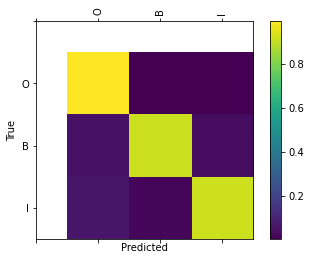

In [19]:
import os.path

DATA_DIR = '/dli/task/data/NCBI_ner-3'
OUTPUT_DIR = '/dli/task/nemo_experiments/token_classification_model/logs'
model.evaluate_from_file(
    text_file=os.path.join(DATA_DIR, 'text_test.txt'),
    labels_file=os.path.join(DATA_DIR, 'labels_test.txt'),
    output_dir=OUTPUT_DIR,
    add_confusion_matrix=True,
    normalize_confusion_matrix=True,
    batch_size=1
)

The results should look something like:

```
[NeMo I 2021-06-29 00:42:16 token_classification_model:499]                  precision    recall  f1-score   support
    
    O (label id: 0)     0.9958    0.9910    0.9934     22450
    B (label id: 1)     0.8886    0.9135    0.9009       960
    I (label id: 2)     0.8724    0.9374    0.9038      1087
    
           accuracy                         0.9856     24497
          macro avg     0.9189    0.9473    0.9327     24497
       weighted avg     0.9861    0.9856    0.9858     24497


The final confusion matrix visualization shows a bright diagonal, indicating that the predicted label matched the true label with high accuracy for all the label types (IOB).
```

<img src="images/ner_confusion_matrix.png">

---
# 3.4 Inference
To run inference on a list of queries, use the same model already loaded with the `add_predictions` method.

In [ ]:
queries = ["Clustering of missense mutations in the ataxia - telangiectasia gene in a sporadic T - cell leukaemia . ",
    "Ataxia - telangiectasia ( A - T ) is a recessive multi - system disorder caused by mutations in the ATM gene at 11q22 - q23 ( ref . 3 ) . ",
    "The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A - T patients and has long been associated with chromosomal instability . ",
    "By analysing tumour DNA from patients with sporadic T - cell prolymphocytic leukaemia ( T - PLL ) , a rare clonal malignancy with similarities to a mature T - cell leukaemia seen in A - T , we demonstrate a high frequency of ATM mutations in T - PLL . ",
    "In marked contrast to the ATM mutation pattern in A - T , the most frequent nucleotide changes in this leukaemia were missense mutations . ",
    "These clustered in the region corresponding to the kinase domain , which is highly conserved in ATM - related proteins in mouse , yeast and Drosophila . ",
    "The resulting amino - acid substitutions are predicted to interfere with ATP binding or substrate recognition . ",
    "Two of seventeen mutated T - PLL samples had a previously reported A - T allele . ",
    "In contrast , no mutations were detected in the p53 gene , suggesting that this tumour suppressor is not frequently altered in this leukaemia . ",
    "Occasional missense mutations in ATM were also found in tumour DNA from patients with B - cell non - Hodgkins lymphomas ( B - NHL ) and a B - NHL cell line . "
          ]

In [ ]:
results = model.add_predictions(queries, output_file='predictions.txt')

In [ ]:
!cat predictions.txt

---
<h2 style="color:green;">Congratulations!</h2>

You've mastered NeMo and learned:
* How to build a named entity recognizer
* How to apply a domain-specific model
* How to test an NER model with queries from a checkpoint

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>